In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import pickle
import itertools
import json
from IPython.display import display as disp

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting, modeleval

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

In [2]:
!/lscr_paper/allan/bin_allan/exa --header -l *.pkl
!/lscr_paper/allan/bin_allan/exa -l ../../allan_data/joachim_exercise*.pkl

Permissions Size User   Date Modified Name
.rw-rw-r--  142k bzg778 17 Sep 16:44  joachim_exercise_resampling_adasyn-logisticregression_resampled.pkl
.rw-rw-r--   54k bzg778 17 Sep 16:09  joachim_exercise_resampling_binarized_sparse_{name}_resampled.pkl
.rw-rw-r--   74k bzg778 17 Sep 16:44  joachim_exercise_resampling_random¬oversampler-logisticregression_resampled.pkl
.rw-rw-r--  143k bzg778 17 Sep 16:44  joachim_exercise_resampling_smote-logisticregression_resampled.pkl
.rw-rw-r--  3.7M bzg778 16 Sep 22:16  joachimExercise_expanded_feature_space_pca_reduction.pkl
.rw-rw-r--  3.0M bzg778  1 Oct 18:11  kernel_pca_lr_predict_sex_roc_curve.pkl
.rw-rw-r--   12k bzg778 15 Nov 19:38  lr_balanced_raw_data.pkl
.rw-rw-r--   12k bzg778 16 Nov  1:06  lr_raw_data.pkl
.rw-rw-r--  17M bzg778 16 Nov  1:08 ../../allan_data/joachim_exercise_kpca_lr.pkl
.rw-rw-r-- 379k bzg778 26 Oct 17:38 ../../allan_data/joachim_exercise_onehot_lr.pkl
.rw-rw-r-- 2.3M bzg778 16 Nov  1:08 ../../allan_data/joachim_exercis

In [3]:
def pkl_load(fname):
    with open(fname, 'br') as fid:
        cv_model = pickle.load(fid)
    return cv_model

In [4]:
cv = pkl_load('joachim_exercise_resampling_adasyn-logisticregression_resampled.pkl')
lr = cv.best_estimator_.named_steps['logisticregression']
coeff = np.concatenate([np.array(lr.intercept_), lr.coef_.flatten()])
sp_adasyn = modeleval.lr_uncertainty(cv.X_test, lr)
sp_adasyn['wald'] = sp_adasyn.coeff / sp_adasyn.stderr

cv = pkl_load('joachim_exercise_resampling_random¬oversampler-logisticregression_resampled.pkl') 
lr = cv.best_estimator_.named_steps['logisticregression']
coeff = np.concatenate([np.array(lr.intercept_), lr.coef_.flatten()])
sp_random_oversampled = modeleval.lr_uncertainty(cv.X_test, lr) 
sp_random_oversampled['wald'] = sp_random_oversampled.coeff / sp_random_oversampled.stderr


cv = pkl_load('joachim_exercise_resampling_smote-logisticregression_resampled.pkl') 
lr = cv.best_estimator_.named_steps['logisticregression']
coeff = np.concatenate([np.array(lr.intercept_), lr.coef_.flatten()])
sp_smote = modeleval.lr_uncertainty(cv.X_test, lr) 
sp_smote['wald'] = sp_smote.coeff / sp_smote.stderr

cv = pkl_load('joachimExercise_expanded_feature_space_pca_reduction.pkl') 
lr = cv.best_estimator_.named_steps['lr']
coeff = np.concatenate([np.array(lr.intercept_), lr.coef_.flatten()])
model = cv.best_estimator_
pca = model.named_steps['pca'] 
X_test = pca.transform(cv.x_va)
sp_expanded_fs_pca = modeleval.lr_uncertainty(X_test, lr)
sp_expanded_fs_pca['wald'] = sp_expanded_fs_pca.coeff / sp_expanded_fs_pca.stderr


In [7]:
sp_adasyn.head(10) 

,coeff,stderr,wald
X0,-0.122440,0.174585,-0.701323
X1,0.118385,0.227846,0.519580
X2,-0.167789,0.215831,-0.777408
X3,-0.088938,0.197799,-0.449638
X4,0.144995,0.239038,0.606577
X5,0.002985,0.198539,0.015033
X6,-0.065217,0.235058,-0.277450
X7,-0.173416,0.254574,-0.681201
X8,0.058779,0.224868,0.261393
X9,0.113128,0.238191,0.474947


In [8]:
sp_random_oversampled.head(10)

,coeff,stderr,wald
X0,-0.129090,0.173637,-0.743451
X1,0.134341,0.227030,0.591734
X2,-0.190288,0.215807,-0.881750
X3,-0.090389,0.196528,-0.459930
X4,0.144905,0.238437,0.607728
X5,-0.034293,0.196541,-0.174482
X6,-0.064693,0.233911,-0.276571
X7,-0.180747,0.253577,-0.712790
X8,0.061138,0.224285,0.272588
X9,0.075254,0.237254,0.317187


In [9]:
sp_smote.head(10)

,coeff,stderr,wald
X0,-0.150647,0.176273,-0.854624
X1,0.155742,0.229641,0.678201
X2,-0.177343,0.217392,-0.815777
X3,-0.104547,0.199302,-0.524563
X4,0.146599,0.240429,0.609739
X5,0.019575,0.200394,0.097681
X6,-0.074612,0.237349,-0.314358
X7,-0.153917,0.256154,-0.600877
X8,0.045600,0.226752,0.201101
X9,0.101221,0.239533,0.422575


In [10]:
sp_expanded_fs_pca.head(10) 

,coeff,stderr,wald
X0,-1.459226,0.249591,-5.846462
X1,-0.001973,0.003705,-0.532433
X2,0.002792,0.004582,0.609259
X3,-0.019178,0.006325,-3.032086
X4,-0.033425,0.007672,-4.356475
X5,-0.002392,0.006533,-0.366179
X6,0.005231,0.007114,0.735314
X7,-0.009383,0.008790,-1.067446
X8,0.004077,0.009127,0.446727
X9,0.000774,0.009596,0.080627


ValueError: operands could not be broadcast together with shapes (940,235) (1892,) 

In [24]:
sp_kpca_lr.head(10)

,coeff,stderr,wald
X0,-0.319982,0.233819,-1.368502
X1,0.000756,0.000600,1.261513
X2,-0.004514,0.000774,-5.835070
X3,0.011592,0.001609,7.205614
X4,-0.010225,0.001647,-6.206499
X5,-0.008112,0.001550,-5.235016
X6,0.003811,0.001063,3.586190
X7,-0.002026,0.002201,-0.920590
X8,0.000795,0.001665,0.477423
X9,0.007378,0.001608,4.588127


Random Oversampled did the best. Not surprising, considering that the answers are integers, which the resampling functions can't handle, and for which cases it likely doesn't makes sense to use the advanced resampling techniques.

AUC: 0.8500631313131313


,coeff,stderr
X0,-0.129090,0.173637
X1,0.134341,0.227030
X2,-0.190288,0.215807
X3,-0.090389,0.196528
X4,0.144905,0.238437
X5,-0.034293,0.196541
X6,-0.064693,0.233911
X7,-0.180747,0.253577
X8,0.061138,0.224285
X9,0.075254,0.237254


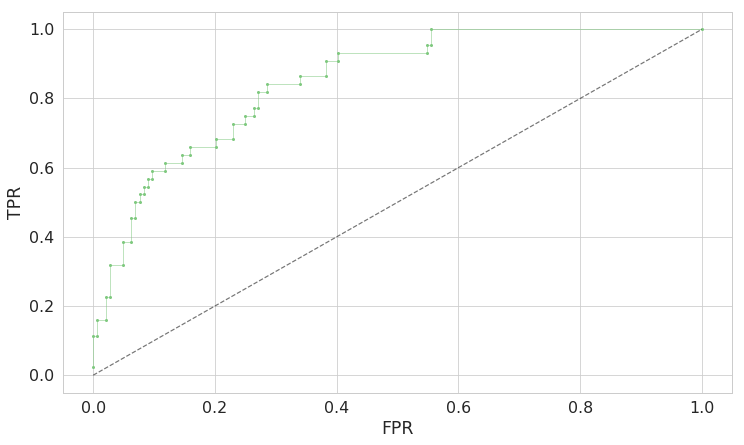

In [37]:
cv = pkl_load('joachim_exercise_resampling_random¬oversampler-logisticregression_resampled.pkl') 
lr = cv.best_estimator_.named_steps['logisticregression'] 

fig, ax = plt.subplots(figsize=(12, 7))
plotting.plotROC(cv.y_test, cv.yhat, xy_guide=True, ax=ax)

modeleval.lr_uncertainty(cv.X_test, lr) 